In [1]:
# Import NumPy for numerical computations (arrays, math operations)
import numpy as np 

# Import Pandas for data handling and analysis (tables, CSV files, etc.)
import pandas as pd 

# Import Matplotlib for data visualization (plots and graphs)
import matplotlib.pyplot as plt

# Ensures plots appear directly inside the notebook (Jupyter/Kaggle)
%matplotlib inline

# Import time module to measure execution time or add delays
import time 

# Import OS module to interact with the operating system
import os

# Walk through the Kaggle input directory and list all available files
# os.walk() traverses folders recursively
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Print the full path of each file found
        print(os.path.join(dirname, filename))

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
# Load the MNIST training dataset from a CSV file into a Pandas DataFrame
# This dataset is used to train the neural network
mnist_train = pd.read_csv(r"/kaggle/input/mnist-in-csv/mnist_train.csv")

# Load the MNIST test dataset from a CSV file into a Pandas DataFrame
# This dataset is used to evaluate the model's performance on unseen data
mnist_test = pd.read_csv(r"/kaggle/input/mnist-in-csv/mnist_test.csv")

In [3]:
mnist_train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Open the MNIST training CSV file in read mode
train_file = open(r"/kaggle/input/mnist-in-csv/mnist_train.csv")

# Read all lines from the training file and store them as a list of strings
# Each line represents one training sample (label + pixel values)
train_list = train_file.readlines()

# Close the training file to free system resources
train_file.close()


# Open the MNIST test CSV file in read mode
test_file = open(r"/kaggle/input/mnist-in-csv/mnist_test.csv")

# Read all lines from the test file and store them as a list of strings
# Each line represents one test sample
test_list = test_file.readlines()

# Close the test file to free system resources
test_file.close()


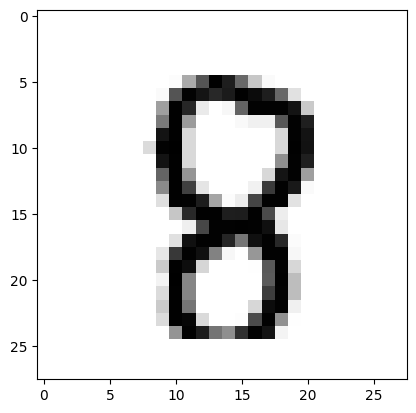

In [6]:
# Extract the 190th record from the training data (index starts from 0)
values = train_list[189].split(",")

# Convert pixel values (excluding the first value, which is the label)
# into a NumPy array and reshape it into a 28x28 image
img_arr = np.asarray(values[1:], dtype="float").reshape((28, 28))

# Display the image using a grayscale color map
# interpolation="None" prevents smoothing so individual pixels are visible
plt.imshow(img_arr, cmap="Grays", interpolation="None")

In [11]:
class DNN:
    # ----------------------------
    # Constructor: initializes the neural network
    # ----------------------------
    def __init__(self, sizes=[784, 128, 64, 10], epochs=10, learning_rate=0.001):
        
        # Store network architecture (number of neurons per layer)
        # 784  -> input layer (28x28 image flattened)
        # 128  -> first hidden layer
        # 64   -> second hidden layer
        # 10   -> output layer (digits 0–9)
        self.sizes = sizes
        
        # Number of training iterations over the dataset
        self.epochs = epochs
        
        # Step size for gradient descent
        self.learning_rate = learning_rate
        
        # Unpack layer sizes for readability
        input_layer = sizes[0]
        hidden_1 = sizes[1]
        hidden_2 = sizes[2]
        output_layer = sizes[3]
        
        # Initialize weight matrices
        # Each weight matrix connects two consecutive layers
        # Shapes:
        # W1: (128, 784)
        # W2: (64, 128)
        # W3: (10, 64)
        #
        # We use scaled random initialization (similar to Xavier initialization)
        # Formula:
        #   W ~ N(0, sqrt(1 / number_of_neurons))
        # This helps prevent exploding or vanishing gradients
        self.params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
        }

    # ----------------------------
    # Sigmoid activation function
    # ----------------------------
    def sigmoid(self, x, derivative=False):
        
        # Sigmoid function:
        #   σ(x) = 1 / (1 + e^(-x))
        # Maps any real value to range (0, 1)
        sig = 1 / (1 + np.exp(-x))
        if derivative:
            # Derivative of sigmoid using σ(x)(1 − σ(x))
            return sig * (1 - sig)
        else:
            return sig

    # ----------------------------
    # Softmax activation function
    # ----------------------------
    def softmax(self, x, derivative=False):
        
        # Subtract max(x) for numerical stability
        # Prevents overflow when computing exp(x)
        exps = np.exp(x - x.max())
        
        # Softmax formula:
        #   softmax(x_i) = exp(x_i) / sum(exp(x_j))
        if derivative:
            # NOTE:
            # This is a simplified (element-wise) version.
            # True softmax derivative is a Jacobian matrix.
            # In practice, softmax + cross-entropy avoids this complexity.
            probs = exps / np.sum(exps, axis=0)
            return probs * (1 - probs)
        else:
            return exps / np.sum(exps, axis=0)

    # ----------------------------
    # Forward propagation
    # ----------------------------
    def forward_pass(self, x_train):
        params = self.params
        
        # A0 = input vector (shape: 784,)
        params["A0"] = x_train
        
        # -------- Layer 1 --------
        # Linear step:
        #   Z1 = W1 · A0
        params["Z1"] = np.dot(params["W1"], params["A0"])
        
        # Activation step:
        #   A1 = sigmoid(Z1)
        params["A1"] = self.sigmoid(params["Z1"])
        
        # -------- Layer 2 --------
        # Z2 = W2 · A1
        params["Z2"] = np.dot(params["W2"], params["A1"])
        
        # A2 = sigmoid(Z2)
        params["A2"] = self.sigmoid(params["Z2"])
        
        # -------- Output Layer --------
        # Z3 = W3 · A2
        params["Z3"] = np.dot(params["W3"], params["A2"])
        
        # A3 = softmax(Z3)
        # Produces probabilities for digits 0–9
        params["A3"] = self.softmax(params["Z3"])
        
        # Return raw output logits (Z3)
        return params["A3"]

    # ----------------------------
    # Backpropagation
    # ----------------------------
    def backward_pass(self, y_train, output):
        """
        Backpropagation using Softmax + Cross-Entropy loss.
    
        y_train : true labels (one-hot encoded)
        output  : predicted probabilities (softmax output)
        """
        
        params = self.params
        change_w = {}
    
        # -------------------------------------------------
        # Output layer gradient (Softmax + Cross-Entropy)
        #
        # dL/dZ3 = y_pred - y_true
        #
        # This works ONLY because:
        # - last activation = softmax
        # - loss function = cross-entropy
        # -------------------------------------------------
        error = output - y_train   # shape: (10,)
    
        # Gradient of W3:
        # dL/dW3 = error ⊗ A2
        change_w["W3"] = np.outer(error, params["A2"])
    
        # -------------------------------------------------
        # Hidden layer 2
        #
        # error = (W3ᵀ · error) ⊙ sigmoid'(Z2)
        # -------------------------------------------------
        error = np.dot(params["W3"].T, error) * self.sigmoid(params["Z2"], derivative=True)
        change_w["W2"] = np.outer(error, params["A1"])
    
        # -------------------------------------------------
        # Hidden layer 1
        #
        # error = (W2ᵀ · error) ⊙ sigmoid'(Z1)
        # -------------------------------------------------
        error = np.dot(params["W2"].T, error) * self.sigmoid(params["Z1"], derivative=True)
        change_w["W1"] = np.outer(error, params["A0"])
    
        return change_w


    # ----------------------------
    # Gradient descent weight update
    # ----------------------------
    def update_weights(self, change_w):
        
        # Gradient descent rule:
        #   W = W - α * dW
        for key, val in change_w.items():
            self.params[key] -= self.learning_rate * val

    # ----------------------------
    # Model evaluation
    # ----------------------------
    def compute_accuracy(self, test_data):
        predictions = []
        
        # Skip header row
        for x in test_data[1:]:
            values = x.split(",")
            
            # Normalize pixel values to range [0.01, 1.0]
            inputs = (np.asarray(values[1:], dtype="float") / 255.0 * 0.99) + 0.01
            
            # One-hot encode target
            targets = np.zeros(10) + 0.01
            targets[int(values[0])] = 0.99
            
            # Forward pass
            output = self.forward_pass(inputs)
            
            # Predicted class = index of max probability
            pred = np.argmax(output)
            
            predictions.append(pred == np.argmax(targets))
        
        # Return accuracy
        return np.mean(predictions)

    # ----------------------------
    # Training loop
    # ----------------------------
    def train(self, train_list, test_list):
        # Store accuracy history
        train_acc_history = []
        test_acc_history = []
        
        # Loop over epochs
        for i in range(self.epochs):
            start_time = time.time()
            
            # Loop over training samples
            for x in train_list[1:]:
                values = x.split(",")
                
                # Normalize input
                inputs = (np.asarray(values[1:], dtype="float") / 255.0 * 0.99) + 0.01
                
                # One-hot target encoding
                targets = np.zeros(10) + 0.01
                targets[int(values[0])] = 0.99
                
                # Forward pass
                output = self.forward_pass(inputs)
                
                # Backpropagation
                change_w = self.backward_pass(targets, output)
                
                # Update weights
                self.update_weights(change_w)
            
            # Evaluate after each epoch
            train_acc = self.compute_accuracy(train_list)
            test_acc = self.compute_accuracy(test_list)
            # Save accuracies
            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
            
            print(
                "Epoch: {0}, Time Spent: {1:.02f}s, Accuracy: {2:.2f}%"
                .format(i + 1, time.time() - start_time, test_acc * 100)
            )

        # Return history for plotting
        return train_acc_history, test_acc_history


In [12]:
# Create an instance of the Deep Neural Network (DNN) class
# sizes = [784, 128, 64, 10]
#   784 → input layer (28x28 MNIST image flattened)
#   128 → first hidden layer neurons
#   64  → second hidden layer neurons
#   10  → output layer (one neuron per digit: 0–9)
#
# epochs = 50
#   The entire training dataset will be passed through the network 50 times
#
# learning_rate = 0.01
#   Controls how big a step gradient descent takes when updating weights
#   Larger values learn faster but can overshoot; smaller values learn slower
dnn = DNN(sizes=[784, 128, 64, 10], epochs=30, learning_rate=0.001)


# Start training the neural network
# train_list → training data (used to update weights)
# test_list  → test data (used only for evaluation, not training)
#
# For each epoch:
#   1. Each training sample is passed forward through the network
#   2. Error is computed using the loss function
#   3. Gradients are calculated via backpropagation
#   4. Weights are updated using gradient descent
#   5. Model accuracy is evaluated on the test dataset
train_acc, test_acc = dnn.train(train_list, test_list)


Epoch: 1, Time Spent: 29.44s, Accuracy: 84.72%
Epoch: 2, Time Spent: 29.55s, Accuracy: 87.97%
Epoch: 3, Time Spent: 29.46s, Accuracy: 89.20%
Epoch: 4, Time Spent: 30.01s, Accuracy: 89.62%
Epoch: 5, Time Spent: 30.08s, Accuracy: 90.14%
Epoch: 6, Time Spent: 29.41s, Accuracy: 90.51%
Epoch: 7, Time Spent: 30.06s, Accuracy: 91.03%
Epoch: 8, Time Spent: 29.80s, Accuracy: 91.46%
Epoch: 9, Time Spent: 29.44s, Accuracy: 91.69%
Epoch: 10, Time Spent: 29.22s, Accuracy: 91.93%
Epoch: 11, Time Spent: 29.24s, Accuracy: 92.13%
Epoch: 12, Time Spent: 29.53s, Accuracy: 92.17%
Epoch: 13, Time Spent: 29.38s, Accuracy: 92.40%
Epoch: 14, Time Spent: 29.00s, Accuracy: 92.55%
Epoch: 15, Time Spent: 29.22s, Accuracy: 92.83%
Epoch: 16, Time Spent: 29.71s, Accuracy: 93.20%
Epoch: 17, Time Spent: 29.52s, Accuracy: 93.44%
Epoch: 18, Time Spent: 29.12s, Accuracy: 93.56%
Epoch: 19, Time Spent: 29.06s, Accuracy: 93.70%
Epoch: 20, Time Spent: 29.01s, Accuracy: 93.82%
Epoch: 21, Time Spent: 29.19s, Accuracy: 93.98%
E

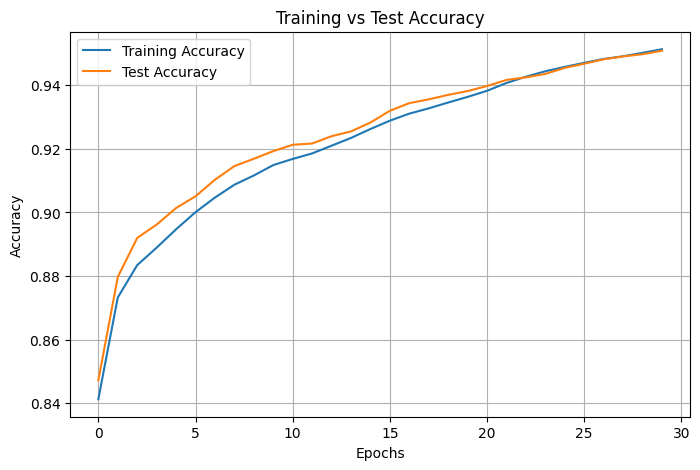

In [13]:
plt.figure(figsize=(8, 5))

plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Test Accuracy")
plt.legend()
plt.grid(True)

plt.show()
